## Жерноклеев Дмитрий 
### Домашнее задание 3. 

### Импортируем необходимые модули

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model # будем работать с модулем mesa
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from tqdm import tqdm
import itertools
%matplotlib inline

### Создадим класс для агентов нашей модели и собственно модели, ориентируясь на работу Дефюэнта. 

In [2]:
class CustomAgent(Agent):
    def __init__(self, unique_id, model, x, u, is_extr=False):
        super().__init__(unique_id, model)
        self.x = x # мнение (число из отрезка [-1, 1])
        self.u = u # степень неуверенности
        self.is_extr = is_extr # флаг, явл. ли экстремистом
    
    def step(self):
        if self.model.pairwise:
            if self.unique_id not in self.model.made_step: 
                other_agent = self.random.choice(self.model.schedule.agents)
                while other_agent.unique_id in self.model.made_step: # чтобы не было повторных взаимод.
                    other_agent = self.random.choice(self.model.schedule.agents)
                if not ((self.x + self.u <= other_agent.x - other_agent.u) 
                    or (self.x - self.u >= other_agent.x + other_agent.u)): # проверяем, будет ли взаимод.      
                    h_ij = (min(self.x + self.u, other_agent.x + other_agent.u)
                        - max(self.x - self.u, other_agent.x - other_agent.u)) # overlap
                    x_other_buf = other_agent.x
                    u_other_buf = other_agent.u
                    if h_ij <= self.u: # (условие из статьи)
                        other_agent.x = other_agent.x
                        other_agent.u = other_agent.u
                    else:
                        other_agent.x = other_agent.x + self.model.mu * (h_ij / self.u - 1) * (self.x - other_agent.x)
                        other_agent.u = other_agent.u + self.model.mu * (h_ij / self.u - 1) * (self.u - other_agent.u)
                        if other_agent.x > 1: # не вышли ли за границы
                            other_agent.x = 1
                        elif other_agent.x < -1:
                            other_agent.x = -1
                        else:
                            other_agent.x = other_agent.x
                    if h_ij <= other_agent.u: # (условие из статьи)
                        self.x = self.x
                        self.u = self.u
                    else:
                        self.x = self.x + self.model.mu * (h_ij / other_agent.u - 1) * (x_other_buf - self.x)
                        self.u = self.u + self.model.mu * (h_ij / u_other_buf - 1) * (u_other_buf - self.u)
                        if self.x > 1: # не вышли ли за границы
                            self.x = 1
                        elif self.x < -1:
                            self.x = -1
                        else:
                            self.x = self.x
                        
                self.model.made_step += [self.unique_id, other_agent.unique_id]
                return _
        else:
            self.x_buf_arr = [] # списки для второго слагаемого (добавки к x_j и u_j) формулы из статьи,
            self.u_buf_arr = [] # которое считаем для взаимодействия j с каждым агентом
            for other_agent in self.model.schedule.agents: # пробегаем по всем агентам
                if other_agent.unique_id != self.unique_id: # кроме нашего
                    if not ((self.x + self.u <= other_agent.x - other_agent.u) # проверяем, будет ли взаимод. 
                        or (self.x - self.u >= other_agent.x + other_agent.u)): # (непустое пересечение интервалов)
                        h_ij = (min(self.x + self.u, other_agent.x + other_agent.u)
                            - max(self.x - self.u, other_agent.x - other_agent.u)) # overlap
                        if h_ij > other_agent.u: # (условие из статьи)
                            x_new = self.model.mu * (h_ij / other_agent.u - 1) * (other_agent.x - self.x) # считаем добавки
                            u_new = self.model.mu * (h_ij / other_agent.u - 1) * (other_agent.u - self.u) # здесь mu = mu/(N-1)
                            if x_new > 1: # не вышли ли за границы
                                x_new = 1
                            elif x_new < -1:
                                x_new = -1
                            self.x_buf_arr.append(x_new) # закидываем в наши листы
                            self.u_buf_arr.append(u_new)
                else:
                    continue 
            # добавляем обновленные значения в буферные листы
            # новые значения считаем как старый x_j + сумма добавок
            self.model.xs[self.unique_id] = self.x + sum(self.x_buf_arr) # / (self.model.num_agents - 1)
            self.model.us[self.unique_id] = self.u + sum(self.u_buf_arr) # / (self.model.num_agents - 1)
            return _

In [3]:
class CustomModel(Model):
    def __init__(self, u, u_e, mu, p_e, delta, N=1000, pairwise=True):
        self.num_agents = N # число агентов N
        self.u = u # степень неуверенности обычных агентов
        self.u_e = u_e # степень неуверенности экстремистов
        self.mu = mu # степень чувствительности к чужому мнению
        self.p_e = p_e # доля экстремистов от N
        self.delta = delta # дельта из статьи 
                           # (относительная разница между долей поз. и нег. экстр.)
        self.pairwise = pairwise # режим взаимодействия
        if self.pairwise == False:
            self.mu /= (self.num_agents - 1)
        
        self.schedule = RandomActivation(self) # добавим шедулер
        x_rand_gen = np.random.uniform(-1, 1, self.num_agents) # нагенерим рандомные x для инициализации агентов
        p_pos_div_p_neg = (1 + self.delta) / (1 - self.delta) # отношение p+/p-, полученное при раскрытии модуля
                                                              # в предположении, что положительных всегда не меньше
        N_neg_extr = int((self.num_agents * self.p_e) / (1 + p_pos_div_p_neg)) # число отриц. экстр.
        N_pos_extr = int(self.num_agents * self.p_e) - N_neg_extr # число полож. экстрем.
                        # формулы вывел на бумаге, еще пользуюсь соображением, что их сумма есть общее число экстрем. 
            
        idxs_neg_extr = np.argpartition(x_rand_gen, N_neg_extr)[:N_neg_extr] # объявляем в качестве экстрем. хвосты слева и справа
        idxs_pos_extr = np.argpartition(x_rand_gen, -N_pos_extr)[-N_pos_extr:] # используя их числа, вычисленные ранее, 
                                                                               # находим индексы экстремистов в массиве мнений x
        if self.pairwise: 
            self.made_step = [] # массив, куда будем закидывать тех, 
                                # кто поучаствовал на шаге в парном взаимодействии
        else:
            self.xs = [0 for _ in range(self.num_agents)] # списки для пересчитанных значений
            self.us = [0 for _ in range(self.num_agents)]
        # Инициализируем агентов и закидываем в шедулер
        for i, x in enumerate(x_rand_gen):
            if (i not in idxs_neg_extr) and (i not in idxs_pos_extr):  
                a = CustomAgent(i, self, x, self.u)
                self.schedule.add(a)
            else:
                a = CustomAgent(i, self, x, self.u_e, True)
                self.schedule.add(a)
                
        self.datacollector = DataCollector(
            agent_reporters={"Opinions": "x"}) # для сбора данных по прогону модели
                
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if self.pairwise:
            self.made_step = []
        else:
            for a in self.schedule.agents:
                a.x = self.xs[a.unique_id]
                a.u = self.us[a.unique_id]
            self.xs = [0 for _ in range(self.num_agents)]
            self.us = [0 for _ in range(self.num_agents)]

### Произведем запуск модели и отрисуем динамику изменения мнений агентов

In [8]:
model = CustomModel(u=1.2, u_e=0.1, mu=0.5, p_e=0.25, delta=0, N=200)
for i in range(225):
    model.step()

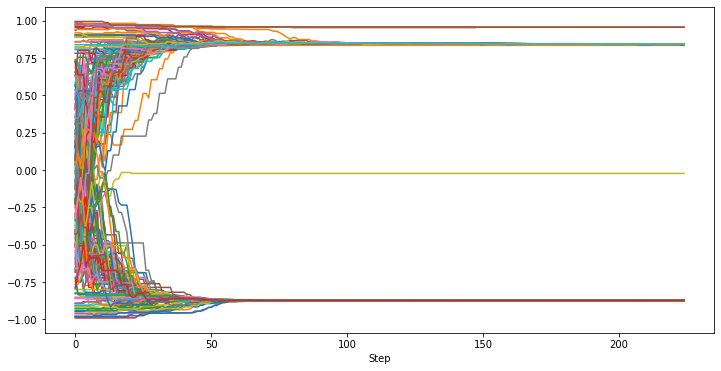

In [9]:
opinion_data = model.datacollector.get_agent_vars_dataframe()
opinion_data.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

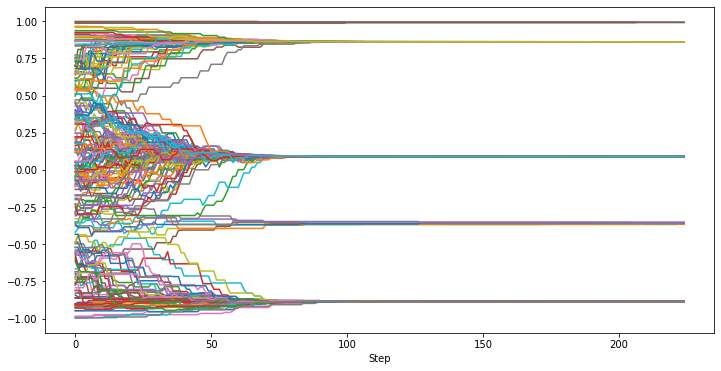

In [11]:
model1 = CustomModel(u=0.4, u_e=0.1, mu=0.5, p_e=0.2, delta=0, N=200)
for i in range(225):
    model1.step()
opinion_data1 = model1.datacollector.get_agent_vars_dataframe()
opinion_data1.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

#### Визуально графики весьма схожи с графиками из статьи для таких же параметров (и парного взаимодействия)

### Теперь посмотрим на режим взаимодействия "все со всеми"

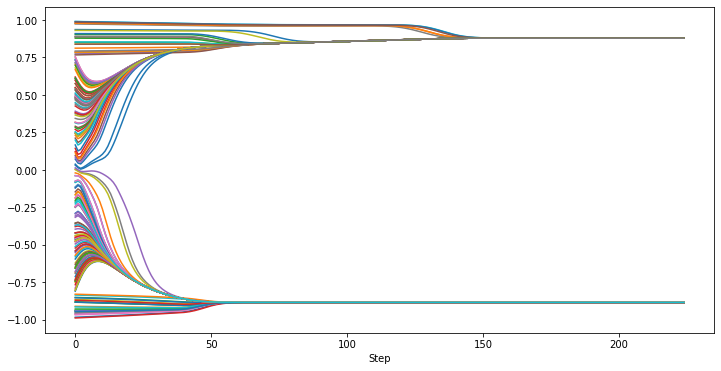

In [16]:
model2 = CustomModel(u=1.2, u_e=0.1, mu=0.5, p_e=0.25, delta=0, N=200, pairwise=False)
for i in range(225):
    model2.step()
opinion_data2 = model2.datacollector.get_agent_vars_dataframe()
opinion_data2.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show() # как я понял, сглаживание происходит из-за усреднения

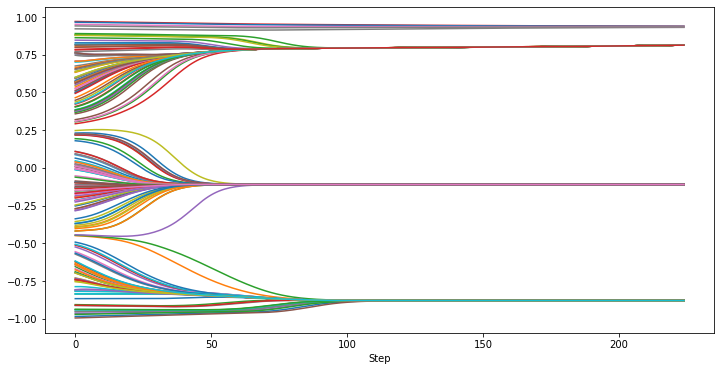

In [21]:
model3 = CustomModel(u=0.4, u_e=0.1, mu=0.5, p_e=0.2, delta=0, N=200, pairwise=False)
for i in range(225):
    model3.step()
opinion_data3 = model3.datacollector.get_agent_vars_dataframe()
opinion_data3.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

### Перейдем к анализу сходимости

In [4]:
eps = 0.005
idx = pd.IndexSlice

#### Сходимость будем проверять, как было предложено на занятии: смотрим, чтобы изменения мнений агентов были меньше заданного $\varepsilon$, точнее будем проверять, чтобы для всех агентов первые разности за последние 5 шагов не выходили за пределы $\varepsilon$-окрестности

Наблюдается сходимость


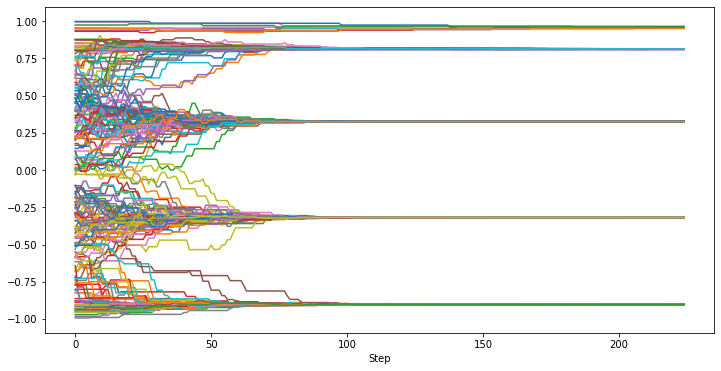

In [16]:
model1_1 = CustomModel(u=0.4, u_e=0.1, mu=0.5, p_e=0.2, delta=0, N=200, pairwise=True)
for i in range(225):
    model1_1.step()
new_df = pd.DataFrame()
opinion_data_buf = model1_1.datacollector.get_agent_vars_dataframe()
for ag_id in list(opinion_data_buf.loc[0].index):   
    new_df = pd.concat((new_df, 
                        opinion_data_buf.loc[idx[:, ag_id], :].droplevel(1).copy().rename(
                            columns={'Opinions':str(ag_id)})), axis=1) 
if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < eps)) == True:
    print('Наблюдается сходимость')
else:
    print('Модель не успела сойтись')
opinion_data1_1 = model1_1.datacollector.get_agent_vars_dataframe()
opinion_data1_1.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

#### Мы установили факт сходимости в конце прогонки модели, теперь попробуем проверять сходимость на каждом шаге и, соответственно, выйдем из цикла, как только установим факт сходимости <br> (поскольку для проверки сходимости производятся операции взятия слайса, копирование, конкатенирование датафреймов, очевидно, что это несколько замедляет процесс исполнения кода, поэтому я постарался провести парой способов оптимизацию, в частности, эмпирически я заметил, что модель почти никогда не сходится к 100 шагу, поэтому и проверку сходимости я начинаю производить после 100 шага)

In [5]:
def conv_check(model, eps=0.005):
    new_df = pd.DataFrame()
    opinion_data_buf = model.datacollector.get_agent_vars_dataframe()
    for ag_id in list(opinion_data_buf.loc[0].index):   
        new_df = pd.concat((new_df, 
                            opinion_data_buf.loc[idx[-15:, ag_id], :].droplevel(1).copy().rename(
                                columns={'Opinions':str(ag_id)})), axis=1) 
    if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < eps)) == True:
        return True

Наблюдается сходимость на шаге 102


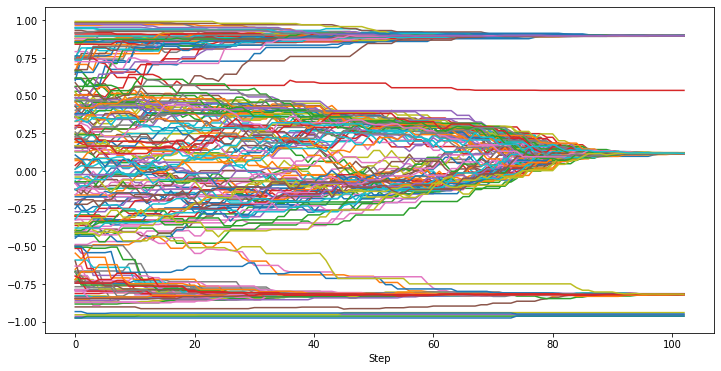

In [26]:
model1_2 = CustomModel(u=0.4, u_e=0.1, mu=0.5, p_e=0.2, delta=0, N=200, pairwise=True)
for i in range(225):
    model1_2.step()
    if i>= 100:
        if conv_check(model1_2) == True:
            print('Наблюдается сходимость на шаге {}'.format(i))
            break        
#         new_df = pd.DataFrame()
#         opinion_data_buf = model1_2.datacollector.get_agent_vars_dataframe()
#         for ag_id in list(opinion_data_buf.loc[0].index):   
#             new_df = pd.concat((new_df, 
#                                 opinion_data_buf.loc[idx[-15:, ag_id], :].droplevel(1).copy().rename(
#                                     columns={'Opinions':str(ag_id)})), axis=1) 
#         if np.all(new_df.iloc[-6:].diff().dropna().apply(lambda x: x < eps)) == True:
#             print('Наблюдается сходимость на шаге {}'.format(i))
#             break
opinion_data1_2 = model1_2.datacollector.get_agent_vars_dataframe()
opinion_data1_2.T.stack().T.plot(legend=False, figsize=(12,6))
plt.show()

#### Чтобы установить, к чему сошлась модель воспользуемся индикатором типа сходимости $y = {p_{+}^\prime}^2 + {p_{-}^\prime}^2$ из статьи.

In [6]:
def conv_type(model):
    p_plus = 0
    p_minus = 0
    for ag in model.schedule.agents:
        if ag.is_extr == False:
            if ag.x >= 1 - 0.25: # (пробовал меньше 0.25, тогда чуть больше значения расходились со статьей)
                p_plus += 1 
            elif ag.x <= -1 + 0.25:
                p_minus -= 1
            else:
                continue
    y = (p_plus / (model.num_agents * (1 - model.p_e))) ** 2 + \
    (p_minus / (model.num_agents * (1 - model.p_e))) ** 2  
    return y

In [17]:
print(conv_type(model1_1))

0.041640625


#### значение индикатора сходимости для модели с параметрами $u=0.4, u_e=0.1, \mu=0.5, p_e=0.2, \delta=0, N=200$ довольно близко к указанному в статье. Посмотрим значение также для, например, набора параметров $u=1.2, u_e=0.1, \mu=0.5, p_e=0.25, \delta=0, N=200$

0.5017777777777778


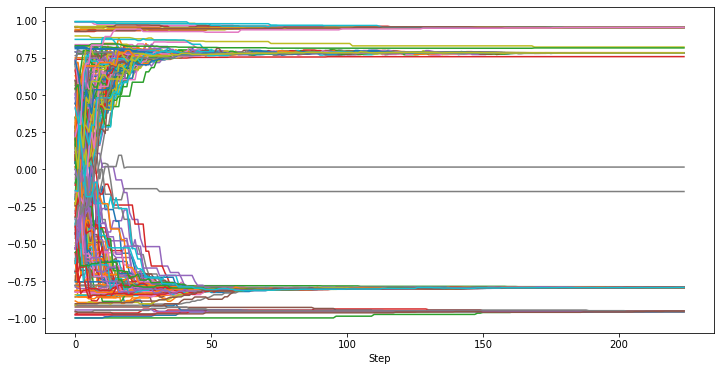

In [41]:
model1_3 = CustomModel(u=1.2, u_e=0.1, mu=0.5, p_e=0.25, delta=0, N=200)
for i in range(225):
    model1_3.step()
opinion_data1_3 = model1_3.datacollector.get_agent_vars_dataframe()
opinion_data1_3.T.stack().T.plot(legend=False, figsize=(12,6))
print(conv_type(model1_3))
plt.show()

#### как видим, значение снова довольно похожее на указанное в статье

1.0


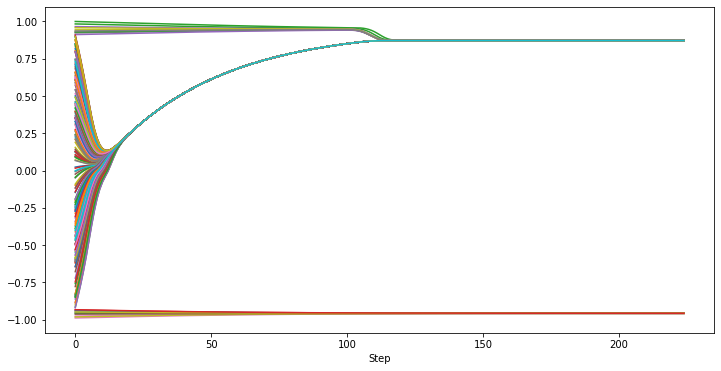

In [7]:
model1_4 = CustomModel(u=1.4, u_e=0.1, mu=0.5, p_e=0.1, delta=0, N=200, pairwise=False)
for i in range(225):
    model1_4.step()
opinion_data1_4 = model1_4.datacollector.get_agent_vars_dataframe()
opinion_data1_4.T.stack().T.plot(legend=False, figsize=(12,6))
print(conv_type(model1_4))
plt.show()

#### для второго режима взаимодействия картина схожа с представленной в статье и значение опять же близко к указанному в статье

#### Перейдем к генерации выборки

In [9]:
train_df = pd.DataFrame(columns=['u', 'u_e', 'mu', 'p_e', 'delta', 'y'])
p_e_lst = [0.05, 0.1, 0.2,  0.3] # 0.25,
u_lst = [ 0.4, 1, 1.2, 1.4] # 0.2, 0.8,
u_e_lst = [ 0.05, 0.1, 0.15, 0.2] # 0.025,
delta_lst = [0,  0.2, 0.4, 0.5] # 0.1,
mu_lst = [0.1, 0.2, 0.4, 0.5] # 0.3,

lists = [u_lst, u_e_lst, mu_lst, p_e_lst, delta_lst]
prod_list = itertools.product(*lists)

In [10]:
for el in prod_list:
    u, u_e, mu, p_e, delta = el
    model_test = CustomModel(u=u, u_e=u_e, mu=mu, p_e=p_e, delta=delta, N=200)
    for i in tqdm(range(500)):
        model_test.step()
    if conv_check(model_test) == True:
        y = conv_type(model_test)
        d = {'u':u, 'u_e':u_e, 'mu':mu, 'p_e':p_e, 
                'delta':delta, 'y':y}
        train_df = train_df.append(d, ignore_index=True)
#         if i >= 150 and i % 50 == 0:
#             if conv_check(model_test) == True:
#                 y = conv_type(model_test)
#                 d = {'u':u, 'u_e':u_e, 'mu':mu, 'p_e':p_e, 
#                         'delta':delta, 'y':y}
#                 train_df = train_df.append(d, ignore_index=True)
#                 #print('Наблюдается сходимость на шаге {}'.format(i))
#                 break  
#         if i == 750:
#             print('Не успела сойтись для:', *el)
#             break

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.61it/s]


#### закоменченный код в предыдущей ячейке для проверки сходимости (он ощутимо замедляет работу, а т.к. время это очень ценный ресурс, когда дедлайн так близок, то я просто решил делать 500 степов, и смотреть в самом конце на сходимость, это оказалось гораздо быстрее) (также отмечу, что проверку на сходимость я выполняю в закоменченном коде каждые 50 шагов, но все равно это медленно)

In [11]:
train_df

,u,u_e,mu,p_e,delta,y
0,0.4,0.05,0.1,0.05,0.5,0.042133
1,0.4,0.05,0.1,0.10,0.2,0.151265
2,0.4,0.05,0.1,0.10,0.4,0.137932
3,0.4,0.05,0.1,0.10,0.5,0.054475
4,0.4,0.05,0.1,0.20,0.0,0.312031
...,...,...,...,...,...,...
824,1.4,0.20,0.5,0.20,0.5,0.709102
825,1.4,0.20,0.5,0.30,0.0,0.222245
826,1.4,0.20,0.5,0.30,0.2,0.500102
827,1.4,0.20,0.5,0.30,0.4,0.090000


In [12]:
train_df.to_csv('def_train.csv', index=False) # закидываем в csv

#### Прогонка модели для режима "все со всеми" куда более времязатратная (в моем случае одна прогонка требует минимум в 10 раз больше времени, чем для режима парного взаимодействия (около 3-4 секунд для парного против 40-50 для "все со всеми")). Однако, я заметил, что конечные картины, получающиеся при одинаковых наборах параметров для этих двух режимов,  в среднем довольно схожи, поэтому можно надеяться, что ML-модель на выборке сгенерированной для парного режима может быть валидна и для второго режима